In [10]:
# IMPORT LIBRARY
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

# LOAD DATA & CLEAN
df = pd.read_csv("../data/credit_scoring.csv")
df_clean = df.drop(columns=['leak_col_good', 'leak_col_subtle'])
print (df)


      application_id  age  monthly_income  loan_amount  previous_defaults  \
0             501000   41        13995609      5982664                  0   
1             501001   58        13683833      3711198                  0   
2             501002   33         9417391      7172332                  0   
3             501003   45         6861811      8661056                  0   
4             501004   22         5640742      4520669                  1   
...              ...  ...             ...          ...                ...   
5995          506995   26        18253018      3690565                  2   
5996          506996   40         9944385      4082038                  1   
5997          506997   28         9048532     14760384                  0   
5998          506998   51         6843160     11774594                  0   
5999          506999   35        12715733      8006387                  0   

      credit_score  default  leak_col_good  leak_col_subtle  
0            

In [11]:
# SPLIT DATA
X = df_clean.drop(columns=['application_id', 'default'])
y = df_clean['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
proba_log = logreg.predict_proba(X_test)[:, 1]
auc_log = roc_auc_score(y_test, proba_log)

# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
proba_gb = gb.predict_proba(X_test)[:, 1]
auc_gb = roc_auc_score(y_test, proba_gb)

# Skor 300–850 dari probabilitas
def to_score(p, bawah=300, atas=850):
    return (1 - p) * (atas - bawah) + bawah

score_gb = to_score(proba_gb)

# Hasil
print(f"AUC Logistic: {auc_log:.4f}")
print(f"AUC Gradien Boosting : {auc_gb:.4f}")

pd.DataFrame({
    'application_id': df_clean.loc[y_test.index, 'application_id'],
    'default_prob': proba_gb,
    'score': score_gb.round()
})


AUC Logistic: 0.7990
AUC Gradien Boosting : 0.7034


,application_id,default_prob,score
1782,502782,0.008490,845.0
3917,504917,0.002204,849.0
221,501221,0.008265,845.0
2135,503135,0.031186,833.0
5224,506224,0.001093,849.0
...,...,...,...
2543,503543,0.062206,816.0
1773,502773,0.001924,849.0
2846,503846,0.000759,850.0
5799,506799,0.007594,846.0


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AUC Logistic: 0.7990
AUC Gradien Boosting : 0.7038


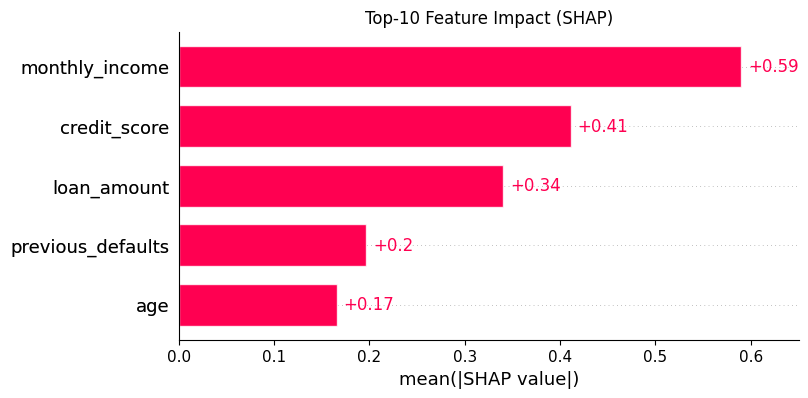

,application_id,score,status
1782,502782,845.0,APPROVE
3917,504917,849.0,APPROVE
221,501221,845.0,APPROVE
2135,503135,833.0,APPROVE
5224,506224,849.0,APPROVE
...,...,...,...
2543,503543,816.0,APPROVE
1773,502773,849.0,APPROVE
2846,503846,850.0,APPROVE
5799,506799,846.0,APPROVE


In [13]:

# Modeling Risiko Kredit

## 1. Import Library & Load Data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import shap
import matplotlib.pyplot as plt
## 2. Muat Dataset & Drop Kolom Leakage
df = pd.read_csv("../data/credit_scoring.csv")
df_clean = df.drop(columns=["leak_col_good", "leak_col_subtle"])
## 3. Preprocessing dan Split Data
X = df_clean.drop(columns=["application_id", "default"])
y = df_clean["default"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
## 4. Baseline Model: Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
proba_log = logreg.predict_proba(X_test)[:, 1]
auc_log = roc_auc_score(y_test, proba_log)
## 5. Gradient Boosting Classifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
proba_gb = gb.predict_proba(X_test)[:, 1]
auc_gb = roc_auc_score(y_test, proba_gb)
## 6. Konversi ke Skor Industri (300–850)
def to_score(p, lo=300, hi=850):
    return (1 - p) * (hi - lo) + lo

score_gb = to_score(proba_gb)
## 7. Tampilkan Hasil
print(f"AUC Logistic: {auc_log:.4f}")
print(f"AUC Gradien Boosting : {auc_gb:.4f}")

pd.DataFrame({
    "application_id": df_clean.loc[y_test.index, "application_id"],
    "default_prob": proba_gb,
    "score": score_gb.round()
}).head()
## 8. Interpretasi SHAP (Top-10 Fitur)
explainer = shap.Explainer(gb, X_train)
shap_values = explainer(X_test)

# Simpan sebagai PNG
plt.figure()
shap.plots.bar(shap_values[:, :10], show=False)
plt.title("Top-10 Feature Impact (SHAP)")
plt.savefig("../notebooks/shap_top10.png")
plt.show()
## 9. Keputusan Skor IDR 5 Juta
# Contoh threshold approval: skor >= 700
decision_threshold = 700
keputusan = pd.DataFrame({
    "application_id": df_clean.loc[y_test.index, "application_id"],
    "score": score_gb.round(),
    "status": np.where(score_gb >= decision_threshold, "APPROVE", "REJECT")
})

# Filter khusus pengajuan 5 juta (kalau punya kolom loan_amount == 5_000_000)
# keputusan[df_clean.loc[y_test.index, 'loan_amount'] == 5_000_000]

keputusan


In [14]:
hasil_validasi = pd.DataFrame({
    "default": y_test.values,
    "pred_prob": proba_log
})
hasil_validasi.to_csv("../data/hltest_input.csv", index=False)

In [15]:
cutoff_df = pd.DataFrame({
    "score": score_gb,
    "actual": y_test.values
})

cutoff_check = (
    cutoff_df
    .groupby(pd.cut(cutoff_df["score"], bins=np.arange(300, 851, 10)))
    .agg(jumlah=('actual', 'count'), gagal=('actual', 'sum'))
    .reset_index()
)
cutoff_check["default_rate"] = cutoff_check["gagal"] / cutoff_check["jumlah"]

# Cari skor minimum dengan default rate ≤ 5%
candidate_cutoff = cutoff_check[cutoff_check["default_rate"] <= 0.05]
cutoff_value = int(candidate_cutoff.iloc[0]["score"].left)
print(f"Cut-off score untuk default rate ≤ 5%: {cutoff_value}")

Cut-off score untuk default rate ≤ 5%: 310


C:\Users\ACER\AppData\Local\Temp\ipykernel_2472\2314423428.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(cutoff_df["score"], bins=np.arange(300, 851, 10)))
